# Description

The notebooks performs an EDA of the given universe of assets.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import pandas as pd

import core.config as cconfig
import core.finance.bid_ask as cfibiask
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.ccxt.data.client as icdcl
import im_v2.common.universe as ivcu
import market_data.market_data_example as mdmadaex

/app/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-ced430a1-d286-4ca7-ac17-93ddcced0d4c.json'
INFO  # Git
  branch_name='CmTask7174_Centralize_get_bid_ask_columns_by_level'
  hash='8d8485293'
  # Last commits:
    * 8d8485293 Toma Jordania CmTask7170: expose universe_version to execution analysis notebook (#7176) (   5 hours ago) Tue Feb 13 12:54:15 2024  (HEAD -> CmTask7174_Centralize_get_bid_ask_columns_by_level, origin/master, origin/HEAD)
    * 66874fec8 Sameep Pote CmTask7179 Display account balance before flattening (#7180)      (  18 hours ago) Mon Feb 12 23:07:04 2024           
    * 45ff312b4 Samarth KaPatel update (#7182)                                                    (  20 hours ago) Mon Feb 12 21:38:17 2024           
# Machine info
  system=Linux
  node name=617f61f51a8b
  release=5.15.0-1052-aws
  version=#57~20.04.1-Ubuntu SMP Mon Jan 15 17:04:56 UTC 2024
  machine=x86_64
  processor=x86_64
  cpu count=8

# Config

In [4]:
config = cconfig.get_config_from_env()
if config:
    # Get config from env when running the notebook via the `run_notebook.py`
    # script, e.g., in the system reconciliation flow.
    _LOG.info("Using config from env vars")
else:
    universe_version = "v7.1"
    config = {
        "universe": {
            "vendor": "CCXT",
            "mode": "trade",
            "version": universe_version,
        },
        "start_timestamp": pd.Timestamp("2023-09-01 00:00:00+00:00", tz="UTC"),
        "end_timestamp": pd.Timestamp("2023-12-31T23:59:59+00:00", tz="UTC"),
        "bid_ask_data": {
            "im_client_config": {
                "universe_version": universe_version,
                # Data currently residing in the test bucket
                "root_dir": "s3://cryptokaizen-unit-test/v3",
                "partition_mode": "by_year_month",
                "dataset": "bid_ask",
                "contract_type": "futures",
                # Data snapshot is not applicable for data version = "v3".
                "data_snapshot": "",
                "version": "v1_0_0",
                "download_universe_version": "v7",
                "tag": "resampled_1min",
                "aws_profile": "ck",
            },
            # TODO(Grisha): for some reason the current filtering mechanism filters out `asset_ids` which
            # makes it impossible to stitch the 2 market data dfs. So adding the necessary columns manually.
            "columns": cfibiask.get_bid_ask_columns_by_level(1)
            + ["asset_id", "full_symbol", "start_ts", "knowledge_timestamp"],
            "column_remap": None,
            "filter_data_mode": "assert",
        },
        "ohlcv_data": {
            "resampling_rule": "D",
        },
        "column_names": {
            "timestamp": "timestamp",
            "full_symbol_column": "full_symbol",
            "close": "close",
            "volume": "volume",
            "volume_notional": "volume_notional",
        },
        "bar_duration": "5T",
    }
    config = cconfig.Config().from_dict(config)
print(config)

universe: 
  vendor: CCXT
  mode: trade
  version: v7.1
start_timestamp: 2023-09-01 00:00:00+00:00
end_timestamp: 2023-12-31 23:59:59+00:00
bid_ask_data: 
  im_client_config: 
    universe_version: v7.1
    root_dir: s3://cryptokaizen-unit-test/v3
    partition_mode: by_year_month
    dataset: bid_ask
    contract_type: futures
    data_snapshot: 
    version: v1_0_0
    download_universe_version: v7
    tag: resampled_1min
    aws_profile: ck
  columns: ['level_1.bid_price.open', 'level_1.bid_price.high', 'level_1.bid_price.low', 'level_1.bid_price.close', 'level_1.bid_price.mean', 'level_1.bid_size.open', 'level_1.bid_size.max', 'level_1.bid_size.min', 'level_1.bid_size.close', 'level_1.bid_size.mean', 'level_1.ask_price.open', 'level_1.ask_price.high', 'level_1.ask_price.low', 'level_1.ask_price.close', 'level_1.ask_price.mean', 'level_1.ask_size.open', 'level_1.ask_size.max', 'level_1.ask_size.min', 'level_1.ask_size.close', 'level_1.ask_size.mean', 'asset_id', 'full_symbol', 'star

# Universe

In [5]:
# Get full symbol universe.
full_symbols = ivcu.get_vendor_universe(
    config["universe"]["vendor"],
    config["universe"]["mode"],
    version=config["universe"]["version"],
    as_full_symbol=True,
)
_LOG.info("The number of coins in the universe=%s", len(full_symbols))
full_symbols

INFO  The number of coins in the universe=25


['binance::APE_USDT',
 'binance::AVAX_USDT',
 'binance::AXS_USDT',
 'binance::BAKE_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::CRV_USDT',
 'binance::CTK_USDT',
 'binance::DOGE_USDT',
 'binance::DOT_USDT',
 'binance::DYDX_USDT',
 'binance::ETH_USDT',
 'binance::FTM_USDT',
 'binance::GMT_USDT',
 'binance::LINK_USDT',
 'binance::MATIC_USDT',
 'binance::NEAR_USDT',
 'binance::OGN_USDT',
 'binance::RUNE_USDT',
 'binance::SAND_USDT',
 'binance::SOL_USDT',
 'binance::STORJ_USDT',
 'binance::UNFI_USDT',
 'binance::WAVES_USDT',
 'binance::XRP_USDT']

In [6]:
# Get asset ids.
asset_ids = [
    ivcu.string_to_numerical_id(full_symbol) for full_symbol in full_symbols
]
asset_ids

[6051632686,
 8717633868,
 2540896331,
 1528092593,
 8968126878,
 1467591036,
 2476706208,
 5115052901,
 3065029174,
 1891737434,
 3401245610,
 1464553467,
 1966583502,
 1030828978,
 2601760471,
 2683705052,
 9872743573,
 2484635488,
 2099673105,
 4516629366,
 2237530510,
 2425308589,
 1776791608,
 2384892553,
 5118394986]

In [7]:
# Get asset id to full symbol mapping.
asset_id_to_full_symbol_mapping = ivcu.build_numerical_to_string_id_mapping(
    full_symbols
)
asset_id_to_full_symbol_mapping

{6051632686: 'binance::APE_USDT',
 8717633868: 'binance::AVAX_USDT',
 2540896331: 'binance::AXS_USDT',
 1528092593: 'binance::BAKE_USDT',
 8968126878: 'binance::BNB_USDT',
 1467591036: 'binance::BTC_USDT',
 2476706208: 'binance::CRV_USDT',
 5115052901: 'binance::CTK_USDT',
 3065029174: 'binance::DOGE_USDT',
 1891737434: 'binance::DOT_USDT',
 3401245610: 'binance::DYDX_USDT',
 1464553467: 'binance::ETH_USDT',
 1966583502: 'binance::FTM_USDT',
 1030828978: 'binance::GMT_USDT',
 2601760471: 'binance::LINK_USDT',
 2683705052: 'binance::MATIC_USDT',
 9872743573: 'binance::NEAR_USDT',
 2484635488: 'binance::OGN_USDT',
 2099673105: 'binance::RUNE_USDT',
 4516629366: 'binance::SAND_USDT',
 2237530510: 'binance::SOL_USDT',
 2425308589: 'binance::STORJ_USDT',
 1776791608: 'binance::UNFI_USDT',
 2384892553: 'binance::WAVES_USDT',
 5118394986: 'binance::XRP_USDT'}

# Mean daily notional volume

In [8]:
# TODO(Grisha): expose DB stage.
# Get prod `MarketData`.
db_stage = "preprod"
market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(
    asset_ids, db_stage
)
# Load and resample OHLCV data.
ohlcv_data = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    config["start_timestamp"],
    config["end_timestamp"],
    config["bar_duration"],
)
hpandas.df_to_str(ohlcv_data, num_rows=5, log_level=logging.INFO)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/im_v2/devops/env/preprod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: preprod.im_data_db
INFO  Created preprod DB connection: 
 None


/app/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2023-09-01 00:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:59:59+0000', tz='UTC'))]


close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                             volume                                                                                                                                                                                                                                                                                vwap                                                                                                                                                                                                                                                                               
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052  3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105  2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573
2023-09-02 20:05:00-04:00     0.1551    1636.04    25845.5     0.0923       7.54      4.259     0.1999       1.56

In [9]:
# Compute notional volume.
volume_notional = (
    ohlcv_data[config["column_names"]["volume"]]
    * ohlcv_data[config["column_names"]["close"]]
)
hpandas.df_to_str(volume_notional, log_level=logging.INFO)

,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
2023-09-02 20:05:00-04:00,91345.0593,9761241.24332,15121090.6935,212629.2025,814877.206,282643.4242,479833.963,126881.04,922043.824,249233.36277,337703.552,533001.8468,24763.9502,263533.04,442361.81403,512391.924,656958.29066,804532.5333,233871.152,48095.8908,640577.27115,511615.68,423626.448,560050.997,258955.2
2023-09-02 20:10:00-04:00,22285.1532,2596488.61836,9555838.5464,84138.032,864698.6055,101280.4632,299256.5535,118430.52,589603.444,160251.06642,160811.7624,121596.7358,23061.6033,89443.872,453915.53586,210859.5585,316439.11222,243516.454,82666.8481,39753.5369,204866.5926,90756.558,235540.74,564018.7734,67260.852
2023-09-02 20:15:00-04:00,14004.1368,2404765.39878,5121747.4296,165643.7134,425294.3016,48899.5045,124032.9525,163185.36,800877.348,59328.33984,85091.976,50281.3076,33827.0128,38999.24,252462.32235,359774.3764,162913.04113,119892.468,37437.904,21424.7572,231978.38144,71065.86,103482.332,201256.7562,34588.29
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 18:50:00-05:00,461601.6244,9499696.53954,18685070.817,393500.2068,70662.81,807777.7785,351512.0077,334320.676,7239107.34,79440.80832,160446.9196,162301.344,51546.0123,185094.892,563207.8331,666122.7658,827999.63409,401714.9824,247780.3104,6618.7345,1206488.87058,180232.527,1444164.508,644507.5914,482930.824
2023-12-31 18:55:00-05:00,438997.8016,3884421.55532,14305808.0475,411597.0414,76589.7803,641483.005,292026.629,581647.14,5927020.209,98617.34175,190948.0744,190414.624,27997.2,253506.834,703099.63724,775114.4012,575902.08865,375820.494,422303.6695,9886.6628,791145.03,273426.434,680635.648,1032828.7515,533685.02
2023-12-31 19:00:00-05:00,520939.5465,5115033.41562,12047201.1594,256121.609,68494.9941,518955.742,308428.2783,1700325.2,4624753.7,134862.54288,135716.3232,89419.6587,19988.92,194267.103,389120.07965,855394.5345,400268.96229,326396.8618,396286.6852,7393.9554,1704811.38477,178234.614,738628.077,465836.4158,388478.985


In [10]:
# Compute mean daily notional volume.
mdv_notional = (
    volume_notional.resample(config["ohlcv_data"]["resampling_rule"]).sum().mean()
)
mdv_notional = mdv_notional.sort_values(ascending=False).round(2)
# Replace asset ids with full symbols.
mdv_notional.index = [
    asset_id_to_full_symbol_mapping[idx] for idx in mdv_notional.index
]
mdv_notional.name = "mdv_notional"
hpandas.df_to_str(mdv_notional, log_level=logging.INFO)

,mdv_notional
binance::BTC_USDT,10098463707.5
binance::ETH_USDT,4618113482.47
binance::SOL_USDT,1840327947.94
,...
binance::SAND_USDT,75079006.33
binance::WAVES_USDT,52374089.0
binance::CTK_USDT,8718621.02


<Axes: title={'center': 'MDV'}, ylabel='notional'>

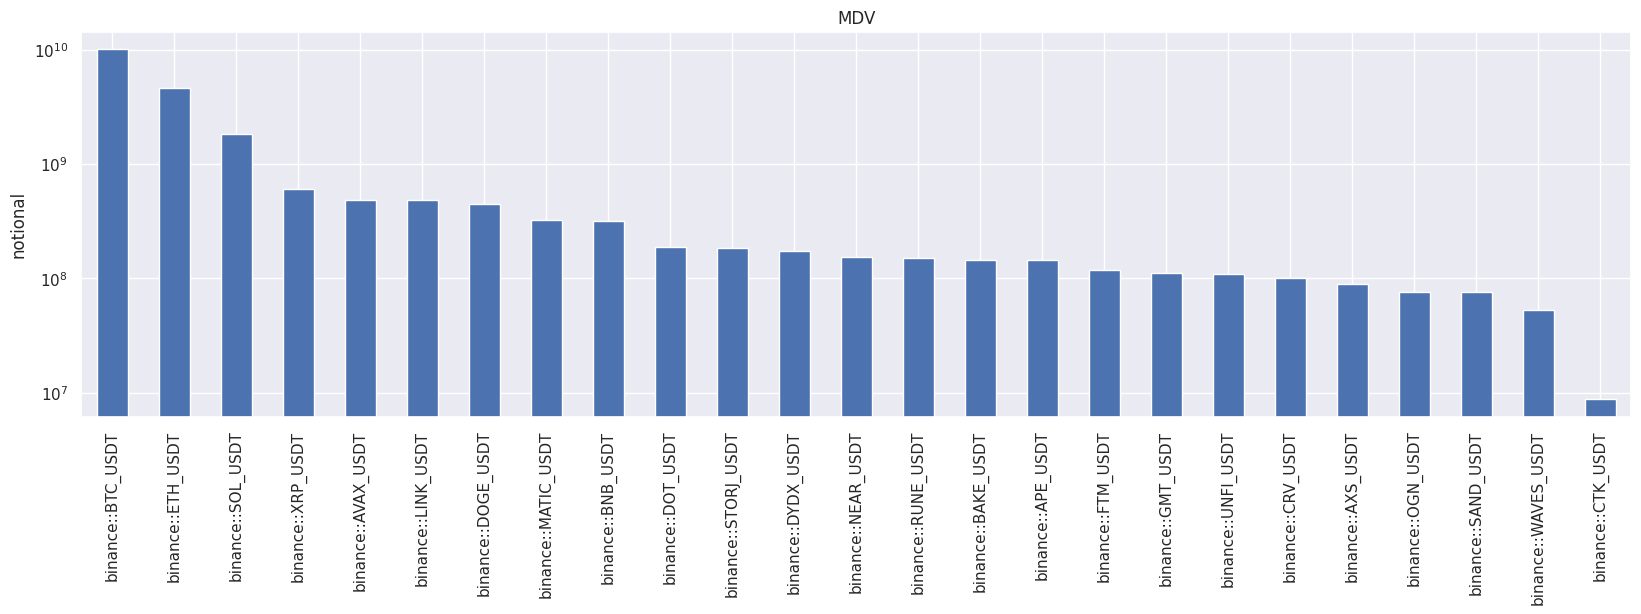

In [11]:
mdv_notional.plot(kind="bar", logy=True, ylabel="notional", title="MDV")

# Bid / ask price changes

In [12]:
bid_ask_im_client = icdcl.ccxt_clients.CcxtHistoricalPqByTileClient(
    **config["bid_ask_data"]["im_client_config"]
)
#
bid_ask_market_data = mdmadaex.get_HistoricalImClientMarketData_example1(
    bid_ask_im_client,
    asset_ids,
    config["bid_ask_data"]["columns"],
    config["bid_ask_data"]["column_remap"],
    filter_data_mode=config["bid_ask_data"]["filter_data_mode"],
)
bid_ask_data = bid_ask_market_data.get_data_for_interval(
    config["start_timestamp"],
    config["end_timestamp"],
    config["column_names"]["timestamp"],
    asset_ids,
)
hpandas.df_to_str(bid_ask_data, log_level=logging.INFO)

,asset_id,full_symbol,level_1.bid_price.open,level_1.bid_price.high,level_1.bid_price.low,level_1.bid_price.close,level_1.bid_price.mean,level_1.bid_size.open,level_1.bid_size.max,level_1.bid_size.min,level_1.bid_size.close,level_1.bid_size.mean,level_1.ask_price.open,level_1.ask_price.high,level_1.ask_price.low,level_1.ask_price.close,level_1.ask_price.mean,level_1.ask_size.open,level_1.ask_size.max,level_1.ask_size.min,level_1.ask_size.close,level_1.ask_size.mean,knowledge_timestamp,start_ts
2023-09-10 20:01:00-04:00,1030828978,binance::GMT_USDT,0.1512,0.1512,0.1509,0.1511,0.151082,66365.0,252684.0,11780.0,189866.0,88425.785714,0.1513,0.1513,0.151,0.1512,0.151182,75861.0,116590.0,12006.0,34750.0,59818.066667,2023-09-19 14:47:21.627940+00:00,2023-09-10 20:00:00-04:00
2023-09-10 20:01:00-04:00,1464553467,binance::ETH_USDT,1616.46,1617.21,1616.46,1617.03,1617.006498,96.056,176.82,0.01,81.301,51.149008,1616.47,1617.22,1616.47,1617.04,1617.017342,26.691,193.07,0.001,9.077,60.578127,2023-09-19 14:47:21.627940+00:00,2023-09-10 20:00:00-04:00
2023-09-10 20:01:00-04:00,1467591036,binance::BTC_USDT,25828.4,25835.7,25828.4,25835.7,25833.086667,3.307,40.841,0.047,4.403,16.718008,25828.5,25835.8,25828.5,25835.8,25833.18875,9.038,24.754,0.005,10.631,6.13795,2023-09-19 14:47:21.627940+00:00,2023-09-10 20:00:00-04:00
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 20:00:00-04:00,8717633868,binance::AVAX_USDT,11.333,11.337,11.327,11.328,11.332312,105.0,3005.0,2.0,35.0,227.944724,11.334,11.338,11.328,11.329,11.333312,20.0,564.0,3.0,261.0,197.939698,2023-12-05 14:35:08.228722+00:00,2023-10-31 19:59:00-04:00
2023-10-31 20:00:00-04:00,8968126878,binance::BNB_USDT,226.44,226.45,226.34,226.34,226.388267,46.24,123.65,0.03,5.27,43.042574,226.45,226.46,226.35,226.35,226.398267,33.56,195.34,0.49,107.43,57.134356,2023-12-05 14:35:08.228722+00:00,2023-10-31 19:59:00-04:00
2023-10-31 20:00:00-04:00,9872743573,binance::NEAR_USDT,1.333,1.333,1.332,1.332,1.332764,2846.0,58216.0,1211.0,36961.0,14349.931937,1.334,1.334,1.333,1.333,1.333764,19433.0,36496.0,2217.0,6602.0,16205.879581,2023-12-05 14:35:08.228722+00:00,2023-10-31 19:59:00-04:00


In [13]:
# Remove duplicates.
use_index = True
duplicate_columns = [config["column_names"]["full_symbol_column"]]
_LOG.info(
    "The number of rows before removing duplicates=%s", bid_ask_data.shape[0]
)
bid_ask_data = hpandas.drop_duplicates(
    bid_ask_data,
    column_subset=duplicate_columns,
    use_index=use_index,
)
_LOG.info(
    "The number of rows after removing duplicates=%s", bid_ask_data.shape[0]
)

INFO  The number of rows before removing duplicates=294000
INFO  The number of rows after removing duplicates=294000


In [14]:
half_spread = 0.5 * (
    bid_ask_data["level_1.ask_price.close"]
    - bid_ask_data["level_1.bid_price.close"]
)
bid_ask_data["half_spread"] = half_spread
bid_ask_midpoint = 0.5 * (
    bid_ask_data["level_1.ask_price.close"]
    + bid_ask_data["level_1.bid_price.close"]
)
bid_ask_data["bid_ask_midpoint"] = bid_ask_midpoint
bid_ask_data["half_spread_bps"] = 1e4 * half_spread / bid_ask_midpoint
# TODO(Paul): Add more refined bid/ask vol calculations.
n_data_points = 30
bid_vol = (
    bid_ask_data.groupby("full_symbol")["level_1.bid_price.close"]
    .pct_change()
    .rolling(n_data_points)
    .std()
)
bid_ask_data["bid_vol_bps"] = 1e4 * bid_vol
ask_vol = (
    bid_ask_data.groupby("full_symbol")["level_1.ask_price.close"]
    .pct_change()
    .rolling(n_data_points)
    .std()
)
bid_ask_data["ask_vol_bps"] = 1e4 * ask_vol

/tmp/ipykernel_678/2461485889.py:15: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  bid_ask_data.groupby("full_symbol")["level_1.bid_price.close"]
/tmp/ipykernel_678/2461485889.py:22: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  bid_ask_data.groupby("full_symbol")["level_1.ask_price.close"]


In [15]:
hpandas.df_to_str(bid_ask_data, log_level=logging.INFO)

,asset_id,full_symbol,level_1.bid_price.open,level_1.bid_price.high,level_1.bid_price.low,level_1.bid_price.close,level_1.bid_price.mean,level_1.bid_size.open,level_1.bid_size.max,level_1.bid_size.min,level_1.bid_size.close,level_1.bid_size.mean,level_1.ask_price.open,level_1.ask_price.high,level_1.ask_price.low,level_1.ask_price.close,level_1.ask_price.mean,level_1.ask_size.open,level_1.ask_size.max,level_1.ask_size.min,level_1.ask_size.close,level_1.ask_size.mean,knowledge_timestamp,start_ts,half_spread,bid_ask_midpoint,half_spread_bps,bid_vol_bps,ask_vol_bps
2023-09-10 20:01:00-04:00,1030828978,binance::GMT_USDT,0.1512,0.1512,0.1509,0.1511,0.151082,66365.0,252684.0,11780.0,189866.0,88425.785714,0.1513,0.1513,0.151,0.1512,0.151182,75861.0,116590.0,12006.0,34750.0,59818.066667,2023-09-19 14:47:21.627940+00:00,2023-09-10 20:00:00-04:00,0.00005,0.15115,3.307972,NaN,NaN
2023-09-10 20:01:00-04:00,1464553467,binance::ETH_USDT,1616.46,1617.21,1616.46,1617.03,1617.006498,96.056,176.82,0.01,81.301,51.149008,1616.47,1617.22,1616.47,1617.04,1617.017342,26.691,193.07,0.001,9.077,60.578127,2023-09-19 14:47:21.627940+00:00,2023-09-10 20:00:00-04:00,0.005,1617.035,0.030921,NaN,NaN
2023-09-10 20:01:00-04:00,1467591036,binance::BTC_USDT,25828.4,25835.7,25828.4,25835.7,25833.086667,3.307,40.841,0.047,4.403,16.718008,25828.5,25835.8,25828.5,25835.8,25833.18875,9.038,24.754,0.005,10.631,6.13795,2023-09-19 14:47:21.627940+00:00,2023-09-10 20:00:00-04:00,0.05,25835.75,0.019353,NaN,NaN
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 20:00:00-04:00,8717633868,binance::AVAX_USDT,11.333,11.337,11.327,11.328,11.332312,105.0,3005.0,2.0,35.0,227.944724,11.334,11.338,11.328,11.329,11.333312,20.0,564.0,3.0,261.0,197.939698,2023-12-05 14:35:08.228722+00:00,2023-10-31 19:59:00-04:00,0.0005,11.3285,0.441365,4.932311,4.930574
2023-10-31 20:00:00-04:00,8968126878,binance::BNB_USDT,226.44,226.45,226.34,226.34,226.388267,46.24,123.65,0.03,5.27,43.042574,226.45,226.46,226.35,226.35,226.398267,33.56,195.34,0.49,107.43,57.134356,2023-12-05 14:35:08.228722+00:00,2023-10-31 19:59:00-04:00,0.005,226.345,0.220902,4.78018,4.778473
2023-10-31 20:00:00-04:00,9872743573,binance::NEAR_USDT,1.333,1.333,1.332,1.332,1.332764,2846.0,58216.0,1211.0,36961.0,14349.931937,1.334,1.334,1.333,1.333,1.333764,19433.0,36496.0,2217.0,6602.0,16205.879581,2023-12-05 14:35:08.228722+00:00,2023-10-31 19:59:00-04:00,0.0005,1.3325,3.752345,4.769621,4.76782


In [16]:
half_spread_bps_df = bid_ask_data.pivot(
    columns="full_symbol", values="half_spread_bps"
)
hpandas.df_to_str(half_spread_bps_df, log_level=logging.INFO)

full_symbol,binance::APE_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BNB_USDT,binance::BTC_USDT,binance::CRV_USDT,binance::CTK_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DYDX_USDT,binance::ETH_USDT,binance::FTM_USDT,binance::GMT_USDT,binance::LINK_USDT,binance::MATIC_USDT,binance::NEAR_USDT,binance::OGN_USDT,binance::RUNE_USDT,binance::SAND_USDT,binance::SOL_USDT,binance::STORJ_USDT,binance::UNFI_USDT,binance::WAVES_USDT,binance::XRP_USDT
2023-09-10 20:01:00-04:00,4.083299,0.528849,1.138563,5.260389,0.23551,0.019353,11.723329,2.183406,0.815993,1.206418,2.590003,0.030921,2.590003,3.307972,0.831601,0.955932,4.345937,5.552471,3.247808,1.694054,0.274386,1.634788,0.634075,0.330196,1.006137
2023-09-10 20:02:00-04:00,4.086637,0.528905,1.140121,5.271481,0.235588,0.019365,11.723329,1.094691,0.815594,1.207001,2.591345,0.030934,2.591345,3.310162,0.832293,0.95648,4.349717,5.558644,3.252033,1.695203,0.274582,1.646091,0.63593,0.330896,1.00634
2023-09-10 20:03:00-04:00,4.086637,0.529073,1.141422,5.271481,0.235666,0.019362,11.723329,2.185792,0.815328,1.206127,2.594034,0.030936,2.591345,3.310162,0.831324,0.956297,4.345937,5.56483,3.252033,1.695203,0.274718,1.645549,0.636254,0.331049,1.00634
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 19:58:00-04:00,3.766478,0.441404,0.915835,3.838772,0.220746,0.014419,10.427529,1.04395,0.732118,1.123722,2.161228,0.02751,2.073398,2.700513,0.438731,0.785855,3.749531,4.196391,1.701548,1.442793,0.130274,1.171097,0.564493,0.281349,0.833542
2023-10-31 19:59:00-04:00,3.766478,0.44117,0.915835,3.838772,0.220804,0.014421,10.427529,1.04395,0.732332,1.123217,2.163098,0.027516,2.072539,2.701972,0.440044,0.785978,3.749531,4.196391,1.703287,1.442377,0.130196,1.169727,0.564621,0.281302,0.833403
2023-10-31 20:00:00-04:00,3.769318,0.441365,0.916842,3.835827,0.220902,0.014429,10.427529,1.045041,0.73244,1.123974,2.164971,0.027538,2.075119,2.701972,0.440199,0.785855,3.752345,4.199916,1.704449,1.44321,0.130302,1.169727,0.564876,0.281444,0.83382


<Axes: title={'center': 'Half bid/ask spread'}, xlabel='full_symbol', ylabel='bps'>

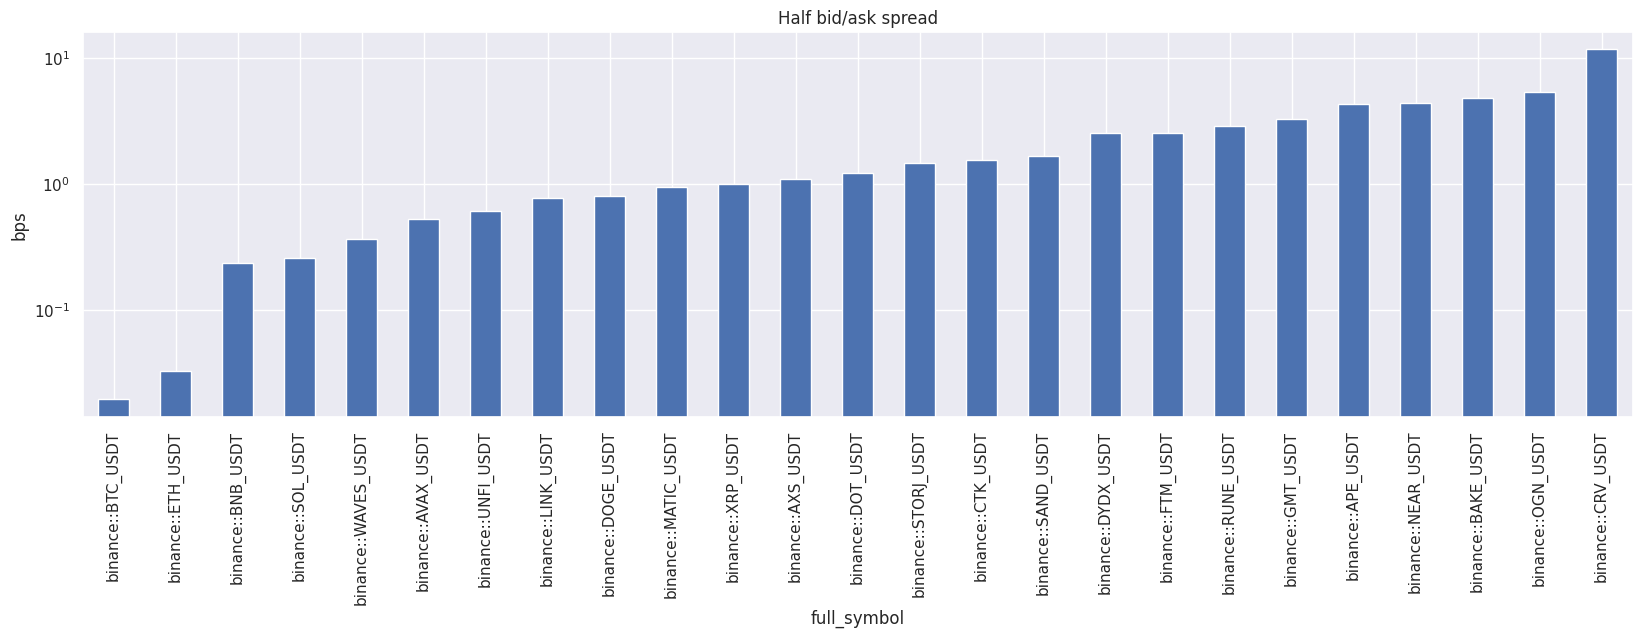

In [17]:
half_spread_bps_mean = (
    half_spread_bps_df.mean().sort_values().rename("half_spread_bps_mean")
)
half_spread_bps_mean.plot(
    kind="bar", logy=True, ylabel="bps", title="Half bid/ask spread"
)

In [18]:
bid_vol_bps_df = bid_ask_data.pivot(columns="full_symbol", values="bid_vol_bps")
hpandas.df_to_str(bid_vol_bps_df, log_level=logging.INFO)

full_symbol,binance::APE_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BNB_USDT,binance::BTC_USDT,binance::CRV_USDT,binance::CTK_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DYDX_USDT,binance::ETH_USDT,binance::FTM_USDT,binance::GMT_USDT,binance::LINK_USDT,binance::MATIC_USDT,binance::NEAR_USDT,binance::OGN_USDT,binance::RUNE_USDT,binance::SAND_USDT,binance::SOL_USDT,binance::STORJ_USDT,binance::UNFI_USDT,binance::WAVES_USDT,binance::XRP_USDT
2023-09-10 20:01:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-10 20:02:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-10 20:03:00-04:00,7.559302,7.540783,13.670502,NaN,7.493363,NaN,13.669984,7.679623,7.263668,14.055906,7.237998,NaN,14.12792,NaN,13.814942,7.18309,6.206055,13.645747,14.213204,6.999935,14.036005,13.611592,13.724014,13.477159,7.66043
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 19:58:00-04:00,8.028636,7.976824,7.600137,10.732729,7.983792,10.748835,8.36618,8.044392,8.050769,10.549485,8.050769,10.796278,10.502095,10.720809,8.042095,8.050769,8.252496,8.153624,10.712604,8.049209,11.920374,8.36618,10.732729,8.346842,8.050509
2023-10-31 19:59:00-04:00,7.318541,7.426049,5.802563,8.195516,7.424767,8.203972,8.594428,7.317016,7.623619,8.102705,7.729493,8.213996,8.120076,8.271669,7.692791,7.622828,7.429767,8.465858,8.164295,7.699998,8.233048,8.60863,8.128706,8.251588,7.318541
2023-10-31 20:00:00-04:00,5.016894,4.932311,7.40406,7.609224,4.78018,7.493109,7.482624,4.971546,6.834445,7.2382,6.859138,7.468221,7.513955,7.37019,7.34985,6.855546,4.769621,7.425677,7.570984,6.826692,7.644236,7.569187,7.208127,7.662506,4.966275


<Axes: title={'center': 'bid vol'}, xlabel='full_symbol', ylabel='bps'>

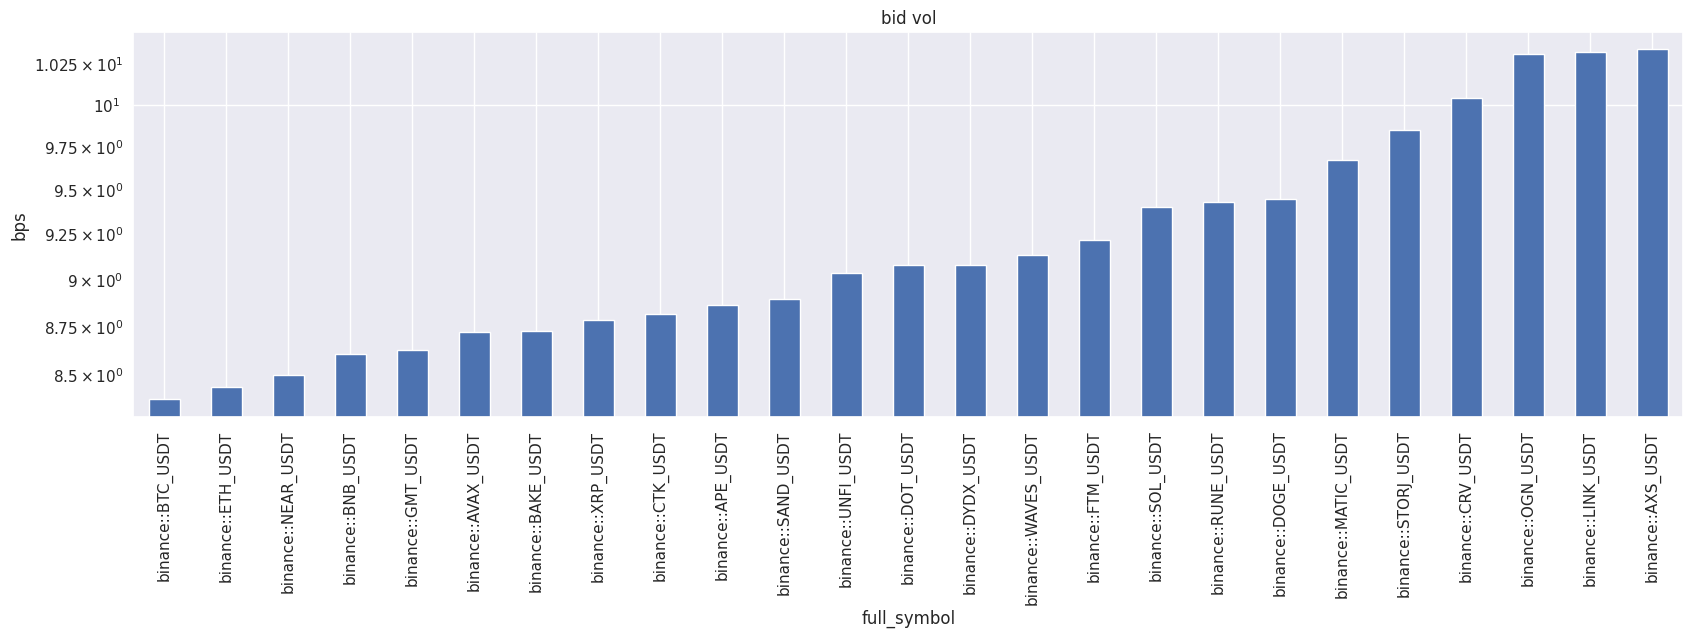

In [19]:
bid_vol_bps_mean = bid_vol_bps_df.mean().sort_values().rename("bid_vol_bps_mean")
bid_vol_bps_mean.plot(kind="bar", logy=True, ylabel="bps", title="bid vol")

In [20]:
bid_vol_to_half_spread = bid_vol_bps_df.divide(half_spread_bps_df)
hpandas.df_to_str(bid_vol_to_half_spread, log_level=logging.INFO)

full_symbol,binance::APE_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BNB_USDT,binance::BTC_USDT,binance::CRV_USDT,binance::CTK_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DYDX_USDT,binance::ETH_USDT,binance::FTM_USDT,binance::GMT_USDT,binance::LINK_USDT,binance::MATIC_USDT,binance::NEAR_USDT,binance::OGN_USDT,binance::RUNE_USDT,binance::SAND_USDT,binance::SOL_USDT,binance::STORJ_USDT,binance::UNFI_USDT,binance::WAVES_USDT,binance::XRP_USDT
2023-09-10 20:01:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-10 20:02:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-10 20:03:00-04:00,1.849761,14.252834,11.976726,NaN,31.796589,NaN,1.16605,3.513427,8.908889,11.653752,2.790248,NaN,5.451964,NaN,16.617994,7.511357,1.428013,2.452141,4.37056,4.129261,51.092463,8.271764,21.570032,40.710454,7.61217
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 19:58:00-04:00,2.131603,18.071494,8.29859,2.795876,36.167375,745.473612,0.802317,7.705723,10.996545,9.387987,3.725091,392.454408,5.06516,3.969915,18.330347,10.244604,2.200941,1.943009,6.295798,5.578907,91.501984,7.143881,19.013029,29.667181,9.658195
2023-10-31 19:59:00-04:00,1.943073,16.832625,6.335819,2.134932,33.626029,568.890467,0.824206,7.00897,10.410052,7.213839,3.573345,298.5188,3.917937,3.061345,17.481867,9.698524,1.981519,2.017414,4.793257,5.338408,63.235571,7.359517,14.396751,29.333571,8.781517
2023-10-31 20:00:00-04:00,1.330982,11.175137,8.075608,1.983725,21.639397,519.292692,0.717584,4.757272,9.331068,6.439827,3.168236,271.195754,3.620975,2.727707,16.696654,8.723682,1.271104,1.768054,4.441896,4.730215,58.665689,6.470898,12.760548,27.225652,5.956053


<Axes: title={'center': 'Bid vol / half spread'}, xlabel='full_symbol'>

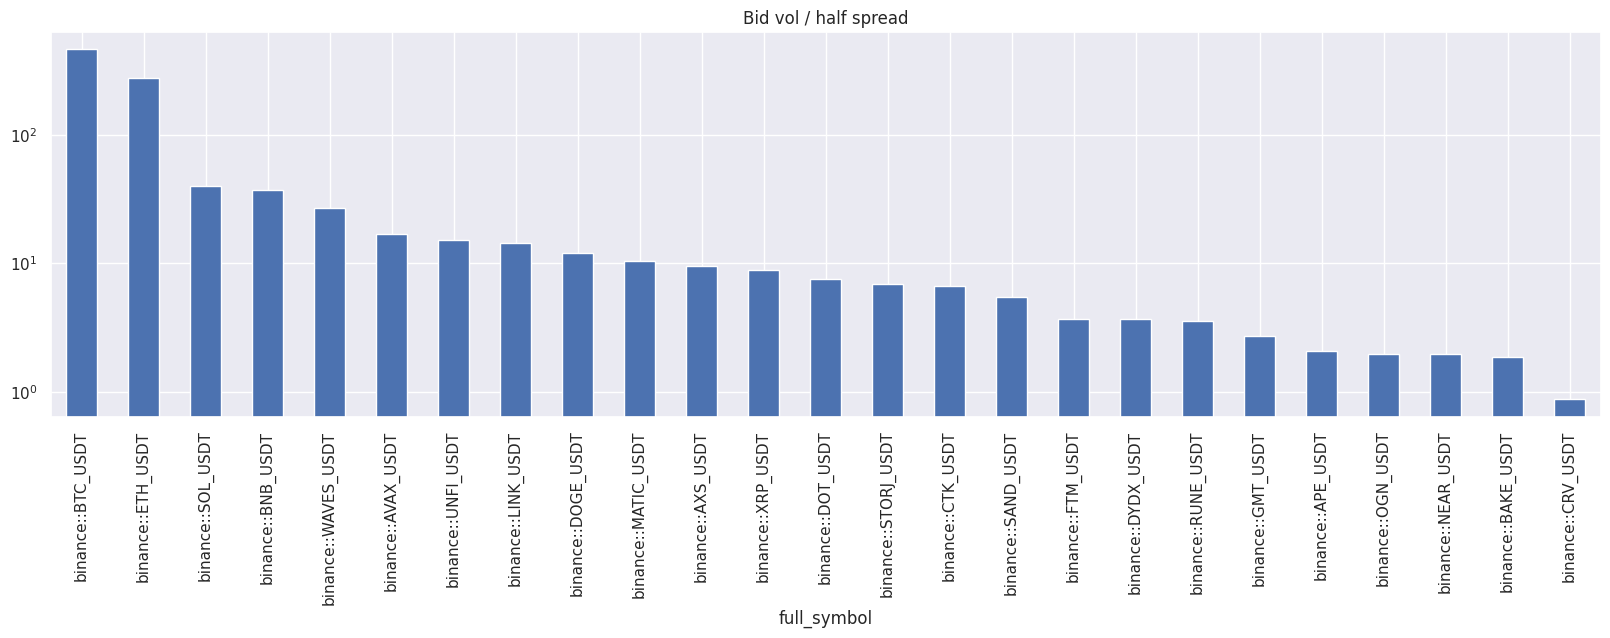

In [21]:
bid_vol_to_half_spread_mean = (
    bid_vol_to_half_spread.mean()
    .sort_values(ascending=False)
    .rename("bid_vol_to_half_spread_mean")
)
bid_vol_to_half_spread_mean.plot(
    kind="bar", logy=True, title="Bid vol / half spread"
)

# Compute rank correlation

In [22]:
liquidity_metrics_df = pd.concat(
    [
        mdv_notional,
        half_spread_bps_mean,
        bid_vol_bps_mean,
        bid_vol_to_half_spread_mean,
    ],
    axis=1,
)
liquidity_metrics_df

,mdv_notional,half_spread_bps_mean,bid_vol_bps_mean,bid_vol_to_half_spread_mean
binance::BTC_USDT,1.009846e+10,0.019220,8.373093,461.023992
binance::ETH_USDT,4.618113e+09,0.032402,8.434364,277.455402
binance::SOL_USDT,1.840328e+09,0.257696,9.402577,40.130999
binance::XRP_USDT,6.080525e+08,1.003811,8.785937,8.904406
binance::AVAX_USDT,4.863262e+08,0.526888,8.721217,16.862524
binance::LINK_USDT,4.836988e+08,0.776796,10.326939,14.284138
binance::DOGE_USDT,4.477487e+08,0.802695,9.448302,11.907026
binance::MATIC_USDT,3.236737e+08,0.944710,9.673369,10.444797
binance::BNB_USDT,3.196141e+08,0.234321,8.603388,37.029573
binance::DOT_USDT,1.860904e+08,1.219209,9.078945,7.514856


In [23]:
liquidity_metrics_df.corr(method="spearman")

,mdv_notional,half_spread_bps_mean,bid_vol_bps_mean,bid_vol_to_half_spread_mean
mdv_notional,1.000000,-0.574615,-0.269231,0.550000
half_spread_bps_mean,-0.574615,1.000000,0.220769,-0.995385
bid_vol_bps_mean,-0.269231,0.220769,1.000000,-0.168462
bid_vol_to_half_spread_mean,0.550000,-0.995385,-0.168462,1.000000


In [24]:
liquidity_metrics_df.corr(method="kendall")

,mdv_notional,half_spread_bps_mean,bid_vol_bps_mean,bid_vol_to_half_spread_mean
mdv_notional,1.000000,-0.453333,-0.186667,0.433333
half_spread_bps_mean,-0.453333,1.000000,0.160000,-0.966667
bid_vol_bps_mean,-0.186667,0.160000,1.000000,-0.126667
bid_vol_to_half_spread_mean,0.433333,-0.966667,-0.126667,1.000000
